# Load and viz

[  7   0  84 185 159 151  60  36 222 254 241 198 170  52  67 114  72 163
 227 225 250 229 140  17  66  14  59  21 236 106  83 253 209  18  22 233
 255 129 238  44 249  62 133 187   5   9 205 248  58 126 182  75 251 240
  57  19 221 166   3 203 219  35  38  77  31 224 115   1  61 242 121  40
 207]


,y,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


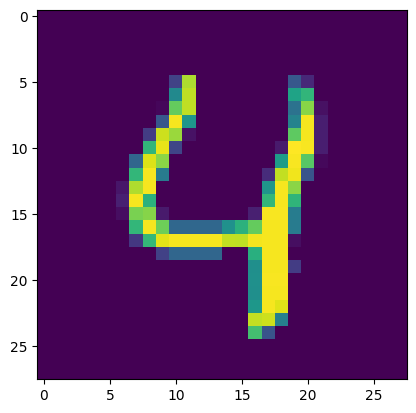

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('data_tp1.csv',header=None)
data = data.rename(columns={0:'y'})
print(data.iloc[0,:].unique())

imsize = round(np.sqrt(784)+1)
linha_y = 4
img = np.reshape(data.iloc[linha_y,1:].values, (imsize-1,imsize-1))
plt.imshow(img)

data.head(2)

# Def data and model shape

In [3]:
from torch.utils.data import DataLoader, Dataset
import torch

from sklearn.model_selection import train_test_split

y = data.y.values
X = data.drop(columns='y').values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

print(X_train.shape)
print(y_train.shape)
idx = 0
print((X_train[idx,:]).shape)
print(y_train[idx])
(y_train[idx]).shape 

# Pytorch exige que seja utilizado um dataset por algum motivo aparentemente
class custom_mnist_dataset():
    def __init__(self, X,y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Restrições de uso do pytorch: (leia os docs...)
        # inputs tem que ser float para multiplicar pelos pesos, 
        # outputs tem que ser longint para calcular crossentropy 
        return torch.tensor(self.X[idx,:], dtype=torch.float), self.y[idx]

training_data = custom_mnist_dataset(X = X_train, y = y_train)
test_data = custom_mnist_dataset(X = X_test, y = y_test)

# batch_size de exemplo para teste
batch_size = 25

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape, type: X: {X.shape} {X.dtype}")
    print(f"Shape, type: y: {y.shape} {y.dtype}")
    break
    

(3350, 784)
(3350,)
(784,)
7
Shape, type: X: torch.Size([25, 784]) torch.float32
Shape, type: y: torch.Size([25]) torch.int64


In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [5]:
from torch import nn
import torch.nn.functional as F

"""
NeuralNetwork with  ...
"""
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(NeuralNetwork, self).__init__()

        self.entrada = nn.Linear(input_size, hidden_dim)
        self.oculta = nn.Linear(hidden_dim, hidden_dim)
        self.saida = nn.Linear(hidden_dim, output_size)

    def forward(self, input):

        x1 = self.entrada(input)
        x2 = F.sigmoid(self.oculta(x1))
        x3 = self.saida(x2)

        return x3
    
# hidden dim = 25,50,100
print(NeuralNetwork(input_size = X_train.shape[1], hidden_dim= 25, output_size=10).to(device))


NeuralNetwork(
  (entrada): Linear(in_features=784, out_features=25, bias=True)
  (oculta): Linear(in_features=25, out_features=25, bias=True)
  (saida): Linear(in_features=25, out_features=10, bias=True)
)


# Def train, test and eval method

In [6]:
# https://www.kaggle.com/code/shrutimechlearn/pytorch-custom-model-step-by-step

def train_step(model, loss_func, optimizer, dataloader):
    
    # to capture loss
    train_loss = 0 

    # to get the model in training mode
    model.train()
    
    for batch, (x_batch, y_batch) in enumerate(dataloader):
        # sending data to the device where rest of the artifacts are
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # forward pass/model prediction with the given input
        y_pred = model(x_batch)
        
        # loss calculation by comparison between predicted and ground truth values
        loss = loss_func(y_pred, y_batch)
        train_loss += loss.item()
    
        # setting previously collected gradient values in the optimizer to zero so it translates only current gradients
        optimizer.zero_grad()
        
        # calculate the gradients for this iteration (independent gradients because previous values have been reset to 0)
        loss.backward()
        
        # update the weights and biases based on the calculated gradients ~(wi = wi + delta_wi)
        optimizer.step()

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)

    return train_loss

In [7]:
def test_step(model, loss_func, test_dataloader):
    
    test_loss = 0
    
    model.eval()
    
    
    with torch.inference_mode():
        
        for batch, (x_batch, y_batch) in enumerate(test_dataloader):
            
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            
            loss = loss_func(y_pred, y_batch)
            test_loss+= loss.item()

    test_loss = test_loss/len(test_dataloader)   

    return test_loss
            

In [8]:
import mlflow
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch import optim

def eval_step_with_mlflowlogging(model,test_dataloader):
        
    with torch.no_grad():
        model.eval()
        total_preds = []
        total_labels = []
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            total_preds.extend(preds.cpu().numpy())
            total_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(total_labels, total_preds)
    precision = precision_score(total_labels, total_preds, average='weighted', labels=np.unique(total_preds))
    recall = recall_score(total_labels, total_preds, average='weighted', labels=np.unique(total_preds))
    f1 = f1_score(total_labels, total_preds, average='weighted', labels=np.unique(total_preds))

    return accuracy, precision, recall, f1

def train_with_mlflowlogging(model, loss_func, optimizer, train_dataloader, test_dataloader, n_epochs, i,lr,hds,bs):
    with mlflow.start_run(run_name=f"Test #{i} - lr({lr}) hds({hds}) bs({bs})", nested = True):  # Name each run based on the learning rate
        mlflow.log_param("batch_size", bs)
        mlflow.log_param("hidden_dim", hds)
        mlflow.log_param("lr", lr)
        
        train_loss = []
        test_loss = []
    
        for epoch in range(n_epochs):
            
            tr_loss = train_step(model, loss_func, optimizer, train_dataloader)
            train_loss.append(tr_loss)
        
            ts_loss = test_step(model, loss_func, test_dataloader)
            test_loss.append(ts_loss)    

            accuracy, precision, recall, f1 = eval_step_with_mlflowlogging(model, test_dataloader)
            
            mlflow.log_metric("loss", tr_loss, step = epoch)
            mlflow.log_metric("val_loss", ts_loss, step = epoch)
            mlflow.log_metric("diff_loss_tr_ts", tr_loss-ts_loss, step = epoch)

            mlflow.log_metric("loss", tr_loss, step = epoch)
            mlflow.log_metric("val_loss", ts_loss, step = epoch)

            mlflow.log_metric("accuracy", accuracy, step = epoch)
            mlflow.log_metric("precision", precision, step = epoch)
            mlflow.log_metric("recall", recall, step = epoch)
            mlflow.log_metric("f1", f1, step = epoch)   

    return train_loss, test_loss


# Def automated trials and logging

In [ ]:
# import optuna
# import torch.optim as optim


# # Assuming the rest of your imports and setup code remains the same

# def objective(trial, lr, hds, bs):
#     # Suggest regularization parameter using the trial object
#     weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
    
#     # Initialize the model with fixed hyperparameters and suggested regularization
#     model = NeuralNetwork(input_size=X_train.shape[1], hidden_dim=hds, output_size=10).to(device)
#     optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

#     # Training and evaluation steps remain the same, just ensure they use the model, loss_func, and optimizer initialized above
#     # Note: You might need to adjust the train_with_mlflowlogging function to remove mlflow logging since we're focusing on Optuna integration now
#     loss_func = nn.CrossEntropyLoss()
    
#     # Example of how you might structure the training and evaluation inside the objective function
#     for epoch in range(5):  # Number of epochs
#         train_loss = train_step(model, loss_func, optimizer, train_dataloader)
#         test_loss = test_step(model, loss_func, test_dataloader)
#         # Evaluate other metrics as needed

#     # Return a value that Optuna will try to minimize/maximize. For example, you could return the negative mean test loss
#     return test_loss

# # Fixed hyperparameters
# fixed_hyperparams = {
#     'learning_rates': [0.5, 1, 10],
#     'hidden_dim_sizes': [25, 50, 100],
#     'batch_sizes': [1, 10, 50, len(training_data)],
# }


# # Iterate over fixed hyperparameters
# best_results = {}
# for lr in fixed_hyperparams['learning_rates']:
#     for hds in fixed_hyperparams['hidden_dim_sizes']:
#         for bs in fixed_hyperparams['batch_sizes']:
#             # Create an Optuna study for each combination
#             study = optuna.create_study(direction='minimize')
#             study.optimize(lambda t: objective(t, lr, hds, bs), n_trials=10)  # Adjust n_trials as needed
            
#             # Record the best trial
#             best_trial = study.best_trial
#             best_weight_decay = best_trial.params['weight_decay']
#             best_test_loss = best_trial.value
            
#             # Record best results
#             best_results[(lr, hds, bs)] = {
#                 'weight_decay': best_weight_decay,
#                 'test_loss': best_test_loss,
#             }

# # Print the best results
# for (lr, hds, bs), result in best_results.items():
#     print(f"Learning Rate: {lr}, Hidden Dimension Size: {hds}, Batch Size: {bs}")
#     print(f"Best Weight Decay: {result['weight_decay']}, Test Loss: {result['test_loss']}")


In [47]:
import optuna
from sklearn.model_selection import StratifiedKFold
import torch.optim as optim
from torch import nn
from datetime import datetime


# Assuming the rest of your imports and setup code remains the same
def train_and_evaluate_model(model, loss_func, optimizer, train_dataloader, val_dataloader, n_epochs, lr, hds, bs,weight_decay):   
    with mlflow.start_run(run_name=f"Testi ", nested = True):  # Name each run based on the learning rate
        mlflow.log_param("weight_decay", weight_decay)
        mlflow.log_param("batch_size", bs)
        mlflow.log_param("hidden_dim", hds)
        mlflow.log_param("lr", lr)        

        model.train()  # Set the model to training mode
        train_losses = []
        val_losses = []
        accuracies = []
        f1_scores = []

        for epoch in range(n_epochs):
            # Training loop
            for inputs, targets in train_dataloader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_func(outputs, targets)
                loss.backward()
                optimizer.step()

            training_loss = loss
            mlflow.log_metric("loss", training_loss, step = epoch)

            # Validation loop
            model.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                total_targets = 0
                total_outputs = 0
                for inputs, targets in val_dataloader:
                    outputs = model(inputs)
                    loss = loss_func(outputs, targets)
                    val_losses.append(loss.item())

                    _, preds = torch.max(outputs, dim=1)
                    total_targets += targets.size(0)
                    total_outputs += torch.sum(preds == targets.data)

            total_labels = targets.numpy()
            total_preds = preds.numpy()
            acc = accuracy_score(total_labels, total_preds)
            # precision = precision_score(total_labels, total_preds, average='weighted', labels=np.unique(total_preds))
            # recall = recall_score(total_labels, total_preds, average='weighted', labels=np.unique(total_preds))
            f1 = f1_score(total_labels, total_preds, average='weighted', labels=np.unique(total_preds))

            # acc = total_outputs / total_targets
            # f1 = f1_score(targets.numpy(), preds.numpy())  # Assuming targets and preds are NumPy arrays

            train_losses.append(loss.item())
            accuracies.append(acc)
            f1_scores.append(f1)

            mlflow.log_metric("val_loss", loss, step = epoch)
            mlflow.log_metric("diff_loss_tr_ts", training_loss-loss, step = epoch)

            mlflow.log_metric("accuracy", acc, step = epoch)
            # mlflow.log_metric("precision", precision, step = epoch)
            # mlflow.log_metric("recall", recall, step = epoch)
            mlflow.log_metric("f1", f1, step = epoch)  

        # return train_losses, val_losses, accuracies, f1_scores
    return train_losses, val_losses, accuracies, f1_scores


def objective(trial, lr, hds, bs, X_train, y_train):
    text = "Experiment - lr({lr}) hds({hds}) bs({bs})".format(lr =lr,hds=hds,bs =bs)
    with mlflow.start_run(run_name=text, experiment_id = mlflow_exp.experiment_id):
        
        # Suggest regularization parameter using the trial object
        weight_decay = trial.suggest_float('weight_decay', 1e-5, 1)
        
        # Initialize the model with fixed hyperparameters and suggested regularization
        model = NeuralNetwork(input_size=X_train.shape[1], hidden_dim=hds, output_size=10).to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
        loss_func = nn.CrossEntropyLoss()
        
        # Perform k-fold cross-validation
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = {"accuracy": [], "f1": []}

        for train_index, val_index in skf.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
            train_dataloader_fold = DataLoader(custom_mnist_dataset(X=X_train_fold, y=y_train_fold), batch_size=bs)
            val_dataloader_fold = DataLoader(custom_mnist_dataset(X=X_val_fold, y=y_val_fold), batch_size=bs)

            # Train and evaluate the model for this fold
            train_loss, test_loss, accuracy, f1 = train_and_evaluate_model(
                model, loss_func, optimizer, train_dataloader_fold, val_dataloader_fold, n_epochs=50, 
                lr=lr, hds=hds, bs=bs, weight_decay = weight_decay)

            # Calculate average scores across all folds
            cv_scores["accuracy"].append(accuracy)
            cv_scores["f1"].append(f1)

        # Return the average cross-validated scores
        mlflow.log_param("weight_decay", weight_decay)
        mlflow.log_param("batch_size", bs)
        mlflow.log_param("hidden_dim", hds)
        mlflow.log_param("lr", lr)      
        mlflow.log_metric("cv-accuracy", np.mean(cv_scores["accuracy"]))
        mlflow.log_metric("cv-f1",  np.mean(cv_scores["f1"]))  
                
        return np.mean(cv_scores["accuracy"]), np.mean(cv_scores["f1"])

# Fixed hyperparameters
fixed_hyperparams = {
    'learning_rates': [0.5, 1, 10],
    'hidden_dim_sizes': [25, 50, 100],
    'batch_sizes': [1, 10, 50, len(training_data)],
}

# watch out for n_trials, n_splits, n_epochs
# Set up MLflow tracking URI
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.autolog()

# Get the current date and time
now = datetime.now()

# Convert to string in the format 'YYYY-MM-DD HH:MM:SS'
formatted_now = now.strftime('%Y%m%dT%H%M%S')

print(formatted_now)

mlflow_exp = mlflow.set_experiment(experiment_name  = 'TP1ML - '+formatted_now)

# Iterate over fixed hyperparameters
best_results = {}
for lr in fixed_hyperparams['learning_rates']:
    for hds in fixed_hyperparams['hidden_dim_sizes']:
        for bs in fixed_hyperparams['batch_sizes']:
            # Create an Optuna study for each combination
            # study = optuna.create_study(direction=('minimize', ('accuracy', 'f1')))
            study_name =  "Study - lr({lr}) hds({hds}) bs({bs}) - ".format(lr =lr,hds=hds,bs =bs)+formatted_now
            study = optuna.create_study(directions=["minimize", "minimize"],study_name =study_name )
            study.optimize(lambda t: objective(t, lr, hds, bs, X_train, y_train), n_trials=5)  # Adjust n_trials as needed
            
            # Record the best trial
            best_trial = study.best_trials[0]
            best_accuracy = best_trial.values[0]
            best_f1 = best_trial.values[1]
            
            # Record best results
            best_results[(lr, hds, bs)] = {
                'best_accuracy': best_accuracy,
                'best_f1': best_f1,
            }
        
        print(best_results[(lr, hds, bs)])

# Print the best results
for (lr, hds, bs), result in best_results.items():
    print(f"Learning Rate: {lr}, Hidden Dimension Size: {hds}, Batch Size: {bs}")
    print(f"Best Accuracy: {result['best_accuracy']}, Best F1 Score: {result['best_f1']}")


2024/06/14 17:14:00 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2024/06/14 17:14:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


20240614T171400


2024/06/14 17:14:02 INFO mlflow.tracking.fluent: Experiment with name 'TP1ML - 20240614T171400' does not exist. Creating a new experiment.
[I 2024-06-14 17:14:02,746] A new study created in memory with name: Study - lr(0.5) hds(25) bs(1) - 20240614T171400
[I 2024-06-14 17:28:57,715] Trial 0 finished with values: [0.192, 0.192] and parameters: {'weight_decay': 0.21959577383015977}. 
[I 2024-06-14 17:43:25,827] Trial 1 finished with values: [0.192, 0.192] and parameters: {'weight_decay': 0.21500514532677525}. 
[I 2024-06-14 17:54:25,419] Trial 2 finished with values: [0.184, 0.184] and parameters: {'weight_decay': 0.44257706530185137}. 
[I 2024-06-14 18:05:01,077] Trial 3 finished with values: [0.196, 0.196] and parameters: {'weight_decay': 0.09553956957123408}. 
[I 2024-06-14 18:15:35,535] Trial 4 finished with values: [0.2, 0.2] and parameters: {'weight_decay': 0.19098081093234126}. 
[I 2024-06-14 18:15:35,535] A new study created in memory with name: Study - lr(0.5) hds(25) bs(10) - 2

{'best_accuracy': 0.12644776119402984, 'best_f1': 0.20268156137405935}


[I 2024-06-14 19:00:25,195] Trial 0 finished with values: [0.188, 0.188] and parameters: {'weight_decay': 0.5446390218350867}. 
[I 2024-06-14 19:19:26,624] Trial 1 finished with values: [0.188, 0.188] and parameters: {'weight_decay': 0.4552508560835999}. 
[I 2024-06-14 19:38:36,799] Trial 2 finished with values: [0.176, 0.176] and parameters: {'weight_decay': 0.778494863828787}. 
[I 2024-06-14 19:57:15,756] Trial 3 finished with values: [0.204, 0.204] and parameters: {'weight_decay': 0.0015404607994889024}. 
[I 2024-06-14 20:16:21,536] Trial 4 finished with values: [0.192, 0.192] and parameters: {'weight_decay': 0.4629116463610798}. 
[I 2024-06-14 20:16:21,536] A new study created in memory with name: Study - lr(0.5) hds(50) bs(10) - 20240614T171400
[I 2024-06-14 20:19:19,133] Trial 0 finished with values: [0.09919999999999998, 0.17404293114293115] and parameters: {'weight_decay': 0.7830846297624006}. 
[I 2024-06-14 20:22:15,931] Trial 1 finished with values: [0.10119999999999998, 0.17

{'best_accuracy': 0.12711044776119404, 'best_f1': 0.21055531854360235}


[I 2024-06-14 21:03:31,545] Trial 0 finished with values: [0.184, 0.184] and parameters: {'weight_decay': 0.47037452419065745}. 
[I 2024-06-14 21:24:08,968] Trial 1 finished with values: [0.176, 0.176] and parameters: {'weight_decay': 0.7996287629957927}. 
[I 2024-06-14 21:44:35,693] Trial 2 finished with values: [0.2, 0.2] and parameters: {'weight_decay': 0.3925602124016348}. 
[I 2024-06-14 22:04:51,970] Trial 3 finished with values: [0.192, 0.192] and parameters: {'weight_decay': 0.12113575838280395}. 
[I 2024-06-14 22:25:27,193] Trial 4 finished with values: [0.18, 0.18] and parameters: {'weight_decay': 0.552613136185498}. 
[I 2024-06-14 22:25:27,193] A new study created in memory with name: Study - lr(0.5) hds(100) bs(10) - 20240614T171400
[I 2024-06-14 22:28:42,422] Trial 0 finished with values: [0.1148, 0.2119708791208791] and parameters: {'weight_decay': 0.09189964249114192}. 
[I 2024-06-14 22:31:53,717] Trial 1 finished with values: [0.10079999999999999, 0.1746550937950938] and

{'best_accuracy': 0.11764776119402984, 'best_f1': 0.19075030429565287}


[I 2024-06-14 23:04:09,870] Trial 0 finished with values: [0.2, 0.2] and parameters: {'weight_decay': 0.8077541123941098}. 
[I 2024-06-14 23:13:52,157] Trial 1 finished with values: [0.2, 0.2] and parameters: {'weight_decay': 0.8911956487986815}. 
[I 2024-06-14 23:23:37,542] Trial 2 finished with values: [0.2, 0.2] and parameters: {'weight_decay': 0.9287766725951332}. 
[I 2024-06-14 23:33:48,954] Trial 3 finished with values: [0.196, 0.196] and parameters: {'weight_decay': 0.08787365325399454}. 
[I 2024-06-14 23:44:15,680] Trial 4 finished with values: [0.2, 0.2] and parameters: {'weight_decay': 0.028488046939587255}. 
[I 2024-06-14 23:44:15,680] A new study created in memory with name: Study - lr(1) hds(25) bs(10) - 20240614T171400
[I 2024-06-14 23:47:25,359] Trial 0 finished with values: [0.10119999999999998, 0.17892701002701006] and parameters: {'weight_decay': 0.48873330745605587}. 
[I 2024-06-14 23:50:31,307] Trial 1 finished with values: [0.098, 0.17355656565656566] and parameter

{'best_accuracy': 0.11386865671641791, 'best_f1': 0.19592595636178156}


[I 2024-06-15 00:28:53,936] Trial 0 finished with values: [0.188, 0.188] and parameters: {'weight_decay': 0.43319070458962194}. 
[I 2024-06-15 00:46:49,282] Trial 1 finished with values: [0.2, 0.2] and parameters: {'weight_decay': 0.36149240461487325}. 
[I 2024-06-15 01:03:51,873] Trial 2 finished with values: [0.196, 0.196] and parameters: {'weight_decay': 0.6142344864190896}. 
[I 2024-06-15 01:21:34,084] Trial 3 finished with values: [0.2, 0.2] and parameters: {'weight_decay': 0.10759361402933605}. 
[I 2024-06-15 01:38:35,613] Trial 4 finished with values: [0.18, 0.18] and parameters: {'weight_decay': 0.523187461382211}. 
[I 2024-06-15 01:38:35,613] A new study created in memory with name: Study - lr(1) hds(50) bs(10) - 20240614T171400
[I 2024-06-15 01:41:35,861] Trial 0 finished with values: [0.10879999999999998, 0.19225087135087138] and parameters: {'weight_decay': 0.036662862954002486}. 
[I 2024-06-15 01:44:35,409] Trial 1 finished with values: [0.11760000000000001, 0.214639872719

{'best_accuracy': 0.11530149253731344, 'best_f1': 0.1955192444341067}


[I 2024-06-15 02:23:51,862] Trial 0 finished with values: [0.2, 0.2] and parameters: {'weight_decay': 0.9715069529194521}. 
[I 2024-06-15 02:41:48,567] Trial 1 finished with values: [0.192, 0.192] and parameters: {'weight_decay': 0.78589074845382}. 
[I 2024-06-15 03:01:01,906] Trial 2 finished with values: [0.188, 0.188] and parameters: {'weight_decay': 0.41956517210792976}. 
[I 2024-06-15 03:18:59,344] Trial 3 finished with values: [0.2, 0.2] and parameters: {'weight_decay': 0.8452990388166546}. 
[I 2024-06-15 03:36:54,985] Trial 4 finished with values: [0.2, 0.2] and parameters: {'weight_decay': 0.6592282579658413}. 
[I 2024-06-15 03:36:54,985] A new study created in memory with name: Study - lr(1) hds(100) bs(10) - 20240614T171400
[I 2024-06-15 03:40:01,106] Trial 0 finished with values: [0.09839999999999997, 0.17169175084175084] and parameters: {'weight_decay': 0.7229758223449322}. 
[I 2024-06-15 03:43:15,125] Trial 1 finished with values: [0.09799999999999999, 0.17388724941724945]

{'best_accuracy': 0.1092179104477612, 'best_f1': 0.18565819725180752}


[I 2024-06-15 04:15:43,390] Trial 0 finished with values: [0.0, 0.0] and parameters: {'weight_decay': 0.8153151002896245}. 
[I 2024-06-15 04:25:15,845] Trial 1 finished with values: [0.0, 0.0] and parameters: {'weight_decay': 0.948927162147763}. 
[I 2024-06-15 04:34:39,534] Trial 2 finished with values: [0.0, 0.0] and parameters: {'weight_decay': 0.7234808057757657}. 
[I 2024-06-15 04:44:05,589] Trial 3 finished with values: [0.0, 0.0] and parameters: {'weight_decay': 0.6993623573611013}. 
[I 2024-06-15 04:53:33,130] Trial 4 finished with values: [0.0, 0.0] and parameters: {'weight_decay': 0.3034188447206517}. 
[I 2024-06-15 04:53:33,130] A new study created in memory with name: Study - lr(10) hds(25) bs(10) - 20240614T171400
[I 2024-06-15 04:56:19,228] Trial 0 finished with values: [0.04, 0.07272727272727274] and parameters: {'weight_decay': 0.9588507205556946}. 
[I 2024-06-15 04:59:03,146] Trial 1 finished with values: [0.04, 0.07272727272727274] and parameters: {'weight_decay': 0.35

{'best_accuracy': 0.09521791044776119, 'best_f1': 0.16838521032625464}


[I 2024-06-15 05:37:00,748] Trial 0 finished with values: [0.0, 0.0] and parameters: {'weight_decay': 0.5983167038913301}. 
[I 2024-06-15 05:53:57,898] Trial 1 finished with values: [0.0, 0.0] and parameters: {'weight_decay': 0.8530436350201308}. 
[I 2024-06-15 06:12:08,692] Trial 2 finished with values: [0.2, 0.2] and parameters: {'weight_decay': 0.033576507924941316}. 
[I 2024-06-15 06:30:30,320] Trial 3 finished with values: [0.2, 0.2] and parameters: {'weight_decay': 0.07502623203456486}. 
[I 2024-06-15 06:49:02,280] Trial 4 finished with values: [0.2, 0.2] and parameters: {'weight_decay': 0.0900948638506418}. 
[I 2024-06-15 06:49:02,280] A new study created in memory with name: Study - lr(10) hds(50) bs(10) - 20240614T171400
[I 2024-06-15 06:52:18,459] Trial 0 finished with values: [0.10119999999999998, 0.17154312354312357] and parameters: {'weight_decay': 0.12814785837400428}. 
[I 2024-06-15 06:55:11,191] Trial 1 finished with values: [0.04, 0.07272727272727274] and parameters: {

{'best_accuracy': 0.0941492537313433, 'best_f1': 0.16941141544823762}


[I 2024-06-15 07:34:42,608] Trial 0 finished with values: [0.0, 0.0] and parameters: {'weight_decay': 0.32985694591643283}. 
[I 2024-06-15 07:52:11,984] Trial 1 finished with values: [0.0, 0.0] and parameters: {'weight_decay': 0.47150346490262296}. 
[I 2024-06-15 08:09:45,976] Trial 2 finished with values: [0.0, 0.0] and parameters: {'weight_decay': 0.9262503398897733}. 
[I 2024-06-15 08:27:14,987] Trial 3 finished with values: [0.0, 0.0] and parameters: {'weight_decay': 0.6928725788725207}. 
[I 2024-06-15 08:44:40,724] Trial 4 finished with values: [0.0, 0.0] and parameters: {'weight_decay': 0.7535128077498956}. 
[I 2024-06-15 08:44:40,725] A new study created in memory with name: Study - lr(10) hds(100) bs(10) - 20240614T171400
[I 2024-06-15 08:47:43,129] Trial 0 finished with values: [0.04, 0.07272727272727274] and parameters: {'weight_decay': 0.9757882840054308}. 
[I 2024-06-15 08:51:01,575] Trial 1 finished with values: [0.10039999999999998, 0.177359595959596] and parameters: {'we

{'best_accuracy': 0.09514626865671644, 'best_f1': 0.17301788007844593}
Learning Rate: 0.5, Hidden Dimension Size: 25, Batch Size: 1
Best Accuracy: 0.184, Best F1 Score: 0.184
Learning Rate: 0.5, Hidden Dimension Size: 25, Batch Size: 10
Best Accuracy: 0.09319999999999999, Best F1 Score: 0.16461659451659452
Learning Rate: 0.5, Hidden Dimension Size: 25, Batch Size: 50
Best Accuracy: 0.1, Best F1 Score: 0.18067340504187468
Learning Rate: 0.5, Hidden Dimension Size: 25, Batch Size: 3350
Best Accuracy: 0.12644776119402984, Best F1 Score: 0.20268156137405935
Learning Rate: 0.5, Hidden Dimension Size: 50, Batch Size: 1
Best Accuracy: 0.176, Best F1 Score: 0.176
Learning Rate: 0.5, Hidden Dimension Size: 50, Batch Size: 10
Best Accuracy: 0.09519999999999999, Best F1 Score: 0.16834254634254633
Learning Rate: 0.5, Hidden Dimension Size: 50, Batch Size: 50
Best Accuracy: 0.0922, Best F1 Score: 0.16189633687505506
Learning Rate: 0.5, Hidden Dimension Size: 50, Batch Size: 3350
Best Accuracy: 0.12